 # Proyecto 2
 ----
  
  Universidad : UTEC \\
  Curso       : Machine Learning \\
  Profesor    : Cristian López Del Alamo \\

 ----
Participantes del equipo :
 - Participante 1: Renzo Acervo (100%)
 - Participante 2: Anthony Guimarey (100%)
 - Participante 3: Lenin Chavez (100%)
 ----


  




## Instalación y declaración de librerías

In [338]:
!pip install tsfresh

import numpy as np
import pandas as pd
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import EfficientFCParameters
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/UTEC/ML/data_proyecto2/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Obtención del dataframe

In [339]:
f_train = h5py.File(f"{path}/train.h5", 'r')
f_train.keys()

<KeysViewHDF5 ['x', 'y']>

In [340]:
X = f_train['x']
x = np.array(X)
x = x[:,0,:]
Y = f_train['y']
y = np.array(Y)

f_test = h5py.File(f"{path}/test.h5", 'r')
x_test = np.array(f_test['x'])
x_test = x_test[:,0,:]
print(x)

both_x =np.concatenate((x, x_test), axis=0) # unimos andos dataframes para que el extractfeatures deje mismos features para ambos

print("Tamaño de la data de entrenamiento:",x.shape)
print("Tamaño de la data de testeo:",x_test.shape)
print("Tamaño de la data junta:", both_x.shape)
print(both_x)

[[-5.859375e-03 -1.141357e-02 -1.077271e-02 ... -1.989746e-02
  -2.163696e-02 -1.885986e-02]
 [ 2.380371e-03  5.126953e-03  5.737305e-03 ... -3.997803e-03
  -5.981445e-03 -7.659912e-03]
 [ 5.807495e-02  1.220398e-01  1.083069e-01 ... -1.315308e-02
  -1.412964e-02 -1.824951e-02]
 ...
 [ 1.516724e-02  3.179932e-02  2.697754e-02 ... -2.716064e-03
  -8.239746e-04  3.051758e-04]
 [ 2.532959e-03  5.218506e-03  3.570557e-03 ... -3.692627e-03
  -3.356934e-03 -3.479004e-03]
 [-2.990723e-03 -4.119873e-03  3.662109e-04 ... -6.103516e-05
  -9.552002e-03 -1.931763e-02]]
Tamaño de la data de entrenamiento: (204, 18530)
Tamaño de la data de testeo: (205, 18530)
Tamaño de la data junta: (409, 18530)
[[-0.00585938 -0.01141357 -0.01077271 ... -0.01989746 -0.02163696
  -0.01885986]
 [ 0.00238037  0.00512695  0.0057373  ... -0.0039978  -0.00598145
  -0.00765991]
 [ 0.05807495  0.1220398   0.1083069  ... -0.01315308 -0.01412964
  -0.01824951]
 ...
 [-0.00698852 -0.01312256 -0.01098633 ...  0.00238037  0.00

### Formateamos el nuevo dataframe

In [341]:
# Crear un DataFrame con los datos originales
df_x_original = pd.DataFrame(both_x)

# Crear un DataFrame vacío para los datos reformateados
df_x = pd.DataFrame()

# Repetir el índice para cada id
idx = np.repeat(np.arange(len(df_x_original)), len(df_x_original.columns))

# Crear la columna 'id'
df_x['id'] = idx

# Crear la columna 'time'
df_x['time'] = np.tile(np.arange(len(df_x_original.columns)), len(df_x_original))

# Crear la columna 'voltage' con los valores de X
df_x['val'] = df_x_original.values.flatten()

# Mostrar las primeras filas del DataFrame reformateado
print(df_x.head())
print(df_x.shape)

   id  time       val
0   0     0 -0.005859
1   0     1 -0.011414
2   0     2 -0.010773
3   0     3 -0.010559
4   0     4 -0.008850
(7578770, 3)


### Extraemos el dataframe con los features dados por TSfresh

In [342]:
#extracted = extract_features(df_x, column_id = 'id', column_sort = 'time',  default_fc_parameters = EfficientFCParameters(), n_jobs=5)

### Guardamos en un csv lo extraído

In [343]:
#extracted.head()
#extracted.to_csv(f"{path}/extracted_features.csv", index=False)

### Separamos data de entrenamiento y testeo

(15,)


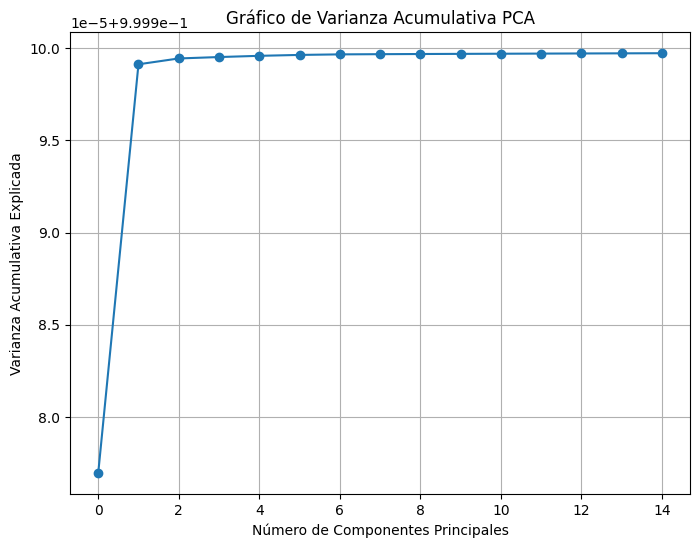

In [344]:
extracted = pd.read_csv(f"{path}/extracted_features.csv")
df_cleaned = extracted.dropna(axis=1)
# Calcular el número de valores únicos en cada columna
unique_counts = df_cleaned.nunique()

# Identificar las columnas que tienen solo un valor único
single_value_columns = unique_counts[unique_counts == 1].index

# Eliminar esas columnas del DataFrame
df_cleaned = df_cleaned.drop(columns=single_value_columns, inplace = False)

df_cleaned.tail()
df_cleaned = np.array(df_cleaned)

pca = PCA(n_components=15)
pca.fit(df_cleaned)
df_cleaned = pca.transform(df_cleaned)

#Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Calcular la varianza acumulativa
cumulative_variance = np.cumsum(explained_variance)
print(np.shape(explained_variance))
# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 15), cumulative_variance[:15], marker='o', linestyle='-')
plt.title('Gráfico de Varianza Acumulativa PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulativa Explicada')
plt.grid(True)

def normalizar(x):
    max_values = x.max(axis=0)  # Obtener los máximos por columna
    min_values = x.min(axis=0)  # Obtener los mínimos por columna
    return (x - min_values) / (max_values - min_values)

In [345]:
df_train_cleaned = df_cleaned[0:204,:]
df_test_cleaned = df_cleaned[204:,:]



print(df_train_cleaned.shape)
print(df_test_cleaned.shape)

X_train, X_val, y_train, y_val = train_test_split(df_train_cleaned, y, test_size=0.2, random_state=12, stratify=y)

(204, 15)
(205, 15)


## Regresión Logística

In [367]:
class LogisticRegression:
    def __init__(self, epsilon=0.00001):
        self.epsilon = epsilon

    def _h(self, x, w):
        return np.dot(x, w)

    def _sigmoid(self, x, w):
        z = self._h(x, w)
        z_clipped = np.clip(z, -500, 500)  # técnica clipping para evitar overflow
        return 1 / (1 + np.exp(-z_clipped))

    def _loss(self, y, y_approx):
        y_approx[y_approx <= self.epsilon] = self.epsilon
        y_approx[y_approx >= 1 - self.epsilon] = 1 - self.epsilon

        loss = y * np.log10(y_approx) + (1 - y) * np.log10(1 - y_approx)
        return -1 * loss.sum() / len(y)

    def _derivatives(self, x, y, w):
        return np.matmul(y - self._sigmoid(x, w), -x) / len(y)

    def _change_parameters(self, w, derivatives, alpha):
        return w - alpha * derivatives

    def _initialize_weights(self, n_features):
        np.random.seed(12)
        return np.array([np.random.rand() for _ in range(n_features)])

    def train(self, x, y, epochs=100, alpha=0.01):
        n_features = x.shape[1]
        w = self._initialize_weights(n_features)
        losses = []

        for _ in range(epochs):
            loss = self._loss(y, self._sigmoid(x, w))
            derivatives = self._derivatives(x, y, w)
            w = self._change_parameters(w, derivatives, alpha)
            losses.append(loss)

        return losses, w

    def test(self, x_test, y_test, w):
        n = len(y_test)
        y_pred = np.round(self._sigmoid(x_test, w))
        matches = np.sum(y_pred == y_test)
        accuracy = matches / n
        print("Number of correct data: ", matches, " out of ", n)
        print("Accuracy: ", accuracy)
        return accuracy

    def predict(self, x_test, w):
        return np.round(self._sigmoid(x_test, w))

### Entrenamiento

In [368]:
model = LogisticRegression()

epochs = 10000

x_norm = X_train
ones_column = np.ones((x_norm.shape[0], 1))
x_norm_log = np.hstack((ones_column, x_norm))

# Entrenamiento
L, W = model.train(x_norm_log, y_train, epochs=epochs, alpha=0.005)

x_val_norm = X_val

ones_column_val = np.ones((x_val_norm.shape[0], 1))
x_val_norm_log = np.hstack((ones_column_val, x_val_norm))
y_val_log = model.predict(x_val_norm_log, W)

print("Real: ",y_val)
print("Predicho: ",y_val_log)
count_ones = np.sum(y_val_log == 1)


print("Number of ones:", count_ones)

print(classification_report(y_val,y_val_log ))

Real:  [0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 1]
Predicho:  [0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
Number of ones: 23
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        30
           1       0.35      0.73      0.47        11

    accuracy                           0.56        41
   macro avg       0.59      0.61      0.55        41
weighted avg       0.70      0.56      0.58        41



### Predicciones

In [369]:
test_norm = normalizar(df_test_cleaned)

ones_column_test = np.ones((test_norm.shape[0], 1))
x_test_norm_log = np.hstack((ones_column_test, test_norm))
y_pred_log = model.predict(x_test_norm_log, W)
print(y_pred_log)
result_csv = pd.DataFrame(y_pred_log)
result_csv = result_csv.reset_index()
result_csv['index'] += 1

result_csv.rename(columns={'index': 'ID', 0: '# result'}, inplace=True)
result_csv.to_csv(f"{path}/results_log.csv", index=False)

[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


## Árbol de decisión

Modificación a partir del código de Patrick Loeber:  [Github](https://github.com/python-engineer/MLfromscratch)

In [349]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None # nodo hoja tiene value


class DTree:
    def __init__(self, min_samples=2, max_depth=1000, n_features=None,criterion = "entropy"):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        self.criterion = criterion

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        np.random.seed(2)
        self.root = self.create_tree(X, y)

    def create_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape # filas, columnas
        num_labels = len(np.unique(y)) # cantidad de clases

        if depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples: # condicion de parada
            leaf_value = self.label_chosen(y) #asignamos valor al nodo al label que se repita más
            return Node(value=leaf_value) # retornamos el nodo con su valor

        feature_indices = np.random.choice(num_features, self.n_features, replace=False) # elegimos num de features que queramos usar, si es none al crear el dt
        # usamos todos los features y al azar
        best_feature, best_threshold = self.best_split(X, y, feature_indices) #best split nos devuelve el mejor feature que debemos usar junto con el rango

        left_indices, right_indices = self.split(X[:, best_feature], best_threshold) # separamos la data segun el threshold
        left = self.create_tree(X[left_indices, :], y[left_indices], depth + 1) # creamos cada subarbol
        right = self.create_tree(X[right_indices, :], y[right_indices], depth + 1)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right) # devolvemos nuestro arbol ya creado

    def best_split(self, X, y, feature_indices):
        best_gain = -1
        split_index, split_threshold = None, None

        for feature_index in feature_indices: # por cada feature iteramos
            X_column = X[:, feature_index] # todas las tuplas con el feature seleccionado
            thresholds = np.unique(X_column) # todos los threshold que probaremos que serán todos los valores únicos en el threshold

            for threshold in thresholds: # por cada valor único
                gain = self.information_gain(y, X_column, threshold) #obtenemos la ganancia utilizando ese limite

                if gain > best_gain: # si es mejor pues nos conviene más que los parámetros que ya estaban seleccionados
                    best_gain = gain
                    split_index = feature_index
                    split_threshold = threshold

        return split_index, split_threshold # devolvemos el mejor feature donde se debe partir y cual es el limite que se escogió

    def information_gain(self, y, X_column, threshold): # Ganancia de información de cada nodo


        left_indices, right_indices = self.split(X_column, threshold)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        num_samples = len(y)
        num_left, num_right = len(left_indices), len(right_indices)

        # Elegiremos según el criterio

        if self.criterion == "entropy":
            parent_entropy = self.entropy(y)
            entropy_left, entropy_right = self.entropy(y[left_indices]), self.entropy(y[right_indices])
            child_entropy = (num_left / num_samples) * entropy_left + (num_right / num_samples) * entropy_right

            information_gain = parent_entropy - child_entropy # formula de inf_gain
            return information_gain
        if self.criterion == "gini":
            parent_gini = self.gini(y)
            gini_left, gini_right = self.gini(y[left_indices]), self.gini(y[right_indices])
            child_gini = (num_left / num_samples) * gini_left + (num_right / num_samples) * gini_right

            information_gain = parent_gini - child_gini #formula de inf_gain
            return information_gain

    def split(self, X_column, split_threshold):
        left_indices = np.argwhere(X_column <= split_threshold).flatten() #vector fila
        right_indices = np.argwhere(X_column > split_threshold).flatten() #vector fila
        return left_indices, right_indices

    def gini(self,y):
        probabilities = np.bincount(y)/ len(y) # frecuencia / # total de elementos de ambas clases
        return 1 - np.sum([p**2 for p in probabilities if p > 0])

    def entropy(self, y):
        probabilities = np.bincount(y) / len(y) # frecuencia / # total de elementos de ambas clases
        return -np.sum([p * np.log(p) for p in probabilities if p > 0])

    def label_chosen(self, y): # elegir label para el nodo
        labels, counts = np.unique(y, return_counts=True)
        most_common = labels[np.argmax(counts)]
        return most_common

    def predict(self, X):
        return np.array([self.return_node_value(x, self.root) for x in X])

    def return_node_value(self, x, node): # recorrer árbol para el resultado
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self.return_node_value(x, node.left)
        return self.return_node_value(x, node.right)


### Entrenamiento

In [359]:
clf = DTree(max_depth=50, criterion = "gini")
clf.fit(X_train, y_train)
y_val_DT = clf.predict(X_val)

print("Real: ",y_val)
print("Predicho: ",y_val_DT)
count_ones = np.sum(y_val_DT == 1)

print("Number of ones:", count_ones)

print(classification_report(y_val,y_val_DT ))

Real:  [0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 1]
Predicho:  [0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1
 0 0 0 1]
Number of ones: 10
              precision    recall  f1-score   support

           0       0.77      0.80      0.79        30
           1       0.40      0.36      0.38        11

    accuracy                           0.68        41
   macro avg       0.59      0.58      0.58        41
weighted avg       0.67      0.68      0.68        41



### Predicciones

In [360]:
y_pred_DT = clf.predict(df_test_cleaned)
print(y_pred_DT)

[1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1
 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0
 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0]


In [374]:
clf = DTree(max_depth=10, criterion = "gini")
clf.fit(df_train_cleaned, y)
y_pred_DT = clf.predict(df_test_cleaned)
print(y_pred_DT)
result_csv = pd.DataFrame(y_pred_DT)
result_csv = result_csv.reset_index()
result_csv['index'] += 1

result_csv.rename(columns={'index': 'ID', 0: '# result'}, inplace=True)
result_csv.to_csv(f"{path}/results_dtree.csv", index=False)

[1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0
 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0]


## SVM


In [352]:
class SVM:
    def h(self,X,w,b):
        return np.dot(X,w.T) + b

    def loss(self,w,y,y_aprox,C):
        margin_err = 1/2 * (np.linalg.norm(w) **2)
        class_err = C * np.sum(np.maximum(0,1 - y * y_aprox))
        L = margin_err + class_err
        return L

    def derivatives(self,x, y, y_aprox, w, b, C):
    # Calcular la matriz de pérdida suavizada
        loss_matrix = 1 - y * y_aprox

    # Aplicar la función de pérdida suavizada
        hinge_loss = np.maximum(0, loss_matrix)
    # Calcular el gradiente de la función de pérdida suavizada con respecto a w
        dw = w + C * np.sum(-y[:, np.newaxis] * x * (hinge_loss > 0)[:, np.newaxis], axis=0)

    # Calcular el gradiente de la función de pérdida suavizada con respecto a b
        db = C * np.sum(-y * (hinge_loss > 0))

        return db, dw

    def Update(self,y,y_aprox,w, b, db, dw, alpha,C):
        w = w - alpha * dw
        b = b - alpha * db
        return w, b

    def training(self, X, Y, C=1, alpha=1e-8, epochs=10000):
        np.random.seed(12)
        w = np.array([np.random.rand() for i in range(X.shape[1])])
        b = np.random.rand()
        error = []
        for i in range(epochs):
            Y_aprox = self.h(X,w,b)
        db, dw = self.derivatives(X, Y,Y_aprox, w, b, C)
        w, b = self.Update(Y,Y_aprox,w, b, db, dw, alpha,C)
        L = self.loss(w,Y,Y_aprox,C)
        error.append(L)
        return w, b, error

    def predict(self,X,W,b):
      y_aprox = []
  # write your code here
      for i in range(X.shape[0]):
          y_aprox.append(np.sign(self.h(X[i],W,b)))
      return np.array(y_aprox)

### Entrenamiento

In [353]:
y_svm_train = np.where(y_train==0,-1,y_train)

svm = SVM()

w, b, error = svm.training(X_train,y_svm_train)

x_val_norm = normalizar(X_val)
y_val_svm = svm.predict(X_val,w,b)
y_val_svm = np.where(y_val_svm==-1,0,y_val_svm)

print("Real: ",y_val)
print("Predicho: ",y_val_svm) # mejor con c = 0.5
count_ones = np.sum(y_val_svm == 1)

print("Number of ones:", count_ones)

print(classification_report(y_val,y_val_svm ))

Real:  [0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 1]
Predicho:  [0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
Number of ones: 23
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        30
           1       0.35      0.73      0.47        11

    accuracy                           0.56        41
   macro avg       0.59      0.61      0.55        41
weighted avg       0.70      0.56      0.58        41



### Predicciones

In [354]:
y_pred_svm = svm.predict(df_test_cleaned,w,b)
y_pred_svm = np.where(y_pred_svm==-1,0,y_pred_svm)
print(y_pred_svm)
result_csv = pd.DataFrame(y_pred_svm)
result_csv = result_csv.reset_index()
result_csv['index'] += 1

result_csv.rename(columns={'index': 'ID', 0: '# result'}, inplace=True)
result_csv.to_csv(f"{path}/results_svm.csv", index=False)

[1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.]


## Conclusión
Es importante mencionar que al final del proyecto lo que nos dió mejor resultado a la hora de subir a kaggle fue el árbol de decisión con gini y max_depth 10, el segundo mejor gini y max_depth 5, ambos entrenados con toda la data de entrenamiento sin usar data de validación, si partimos como en este caso para la presentación mostrando los reportes de clasificación, nos da menos score en el kaggle. SVM y logística predicen demasiadas tuplas como pertenecientes a la clase 1, creemos que es debido a que en svm no hacemos uso de algún kernel como polinomial o rbf, en cuanto a la regresión logística es posible que se deba a que la mayoría de tuplas no se puedan separar bien haciendo uso de una función sigmoide. Una limitación importante es la cantidad de tuplas que tenemos para la data de entrenamiento ya que al ser pocas nuestro modelo no tiene ambas clases bien representadas, tenemos más 0's que 1's, además puede que nuestros modelos esten siendo más susceptibles al ruido ya que como son menos tuplas cada una tiene un mayor peso a la hora de clasificar.